# Import Modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install pymorphy2
!pip install pandas-profiling
!pip install wordcloud
!pip install vaderSentiment
!pip install transformers
!pip install category_encoders
!pip install torch

     -------------------------------------- 55.5/55.5 kB 962.6 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 8.2/8.2 MB 21.9 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=cdfeaad9978b27202e547a4a237e204227bee2bf0751feb6c8da548118b243df
  Stored in directory: c:\users\dasavelko\appdata\local\pip\cache\wheels\70\4a\46\1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt
     -------------------------------------- 324.4/324.4 kB 3.3 MB/s eta 0:00:00
     ------------------------------------- 344.5/344.5 kB 10.8 MB/s eta 0:00:00
     ------------------------------------- 663.5/663.5 kB 21.1 MB/s eta 0:00:00
     ---------------------------------------- 2.1/2.1 MB 34.3 MB/s eta 0:00:00
     ---------------------------------------- 102.7/102.7 kB ? eta 0:00:00
  Preparing metadata (setup.py):

     -------------------------------------- 153.1/153.1 kB 2.3 MB/s eta 0:00:00
     -------------------------------------- 126.0/126.0 kB 1.5 MB/s eta 0:00:00
     ---------------------------------------- 6.3/6.3 MB 15.0 MB/s eta 0:00:00
     ---------------------------------------- 190.3/190.3 kB ? eta 0:00:00
     ---------------------------------------- 3.3/3.3 MB 23.3 MB/s eta 0:00:00
     ---------------------------------------- 81.2/81.2 kB 1.1 MB/s eta 0:00:00
     -------------------------------------- 162.5/162.5 MB 9.6 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string 
import pymorphy2
import re
import torch
import warnings
import transformers
import os
import torch.nn.functional as F
warnings.filterwarnings("ignore")

from collections import defaultdict
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
from torch import nn, optim
from typing import List, Tuple
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import AutoModel

# Prepocessing Data

In [ ]:
from sklearn.model_selection import train_test_split

data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_train, df_test = train_test_split(data, test_size=0.1, random_state=42)

In [ ]:
data.shape

(7613, 5)

In [ ]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [ ]:
data['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(data, title="Pandas Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Feature Engineering
Clear the data by regex

In [ ]:
df_train.head()

,id,keyword,location,text,target
4620,6568,injury,"Plano, Texas",'McFadden Reportedly to Test Hamstring Thursda...,0
2858,4107,drought,Nigeria,w--=-=-=-[ NEMA warns Nigerians to prepare for...,1
3098,4448,electrocuted,NaN,When I was cooking earlier I got electrocuted ...,0
3751,5330,fire,Canada,I'm On Fire. http://t.co/WATsmxYTVa,0
5285,7552,outbreak,Indonesia,More than 40 families affected by the fatal ou...,1


Compare `keyword` and `location` columns with **NaN** and without **NaN**

In [ ]:
df_train['isna_keyword'] = df_train['keyword'].isna()
df_train['isna_location'] = df_train['location'].isna()
df_train.head()

,id,keyword,location,text,target,isna_keyword,isna_location
4620,6568,injury,"Plano, Texas",'McFadden Reportedly to Test Hamstring Thursda...,0,False,False
2858,4107,drought,Nigeria,w--=-=-=-[ NEMA warns Nigerians to prepare for...,1,False,False
3098,4448,electrocuted,NaN,When I was cooking earlier I got electrocuted ...,0,False,True
3751,5330,fire,Canada,I'm On Fire. http://t.co/WATsmxYTVa,0,False,False
5285,7552,outbreak,Indonesia,More than 40 families affected by the fatal ou...,1,False,False


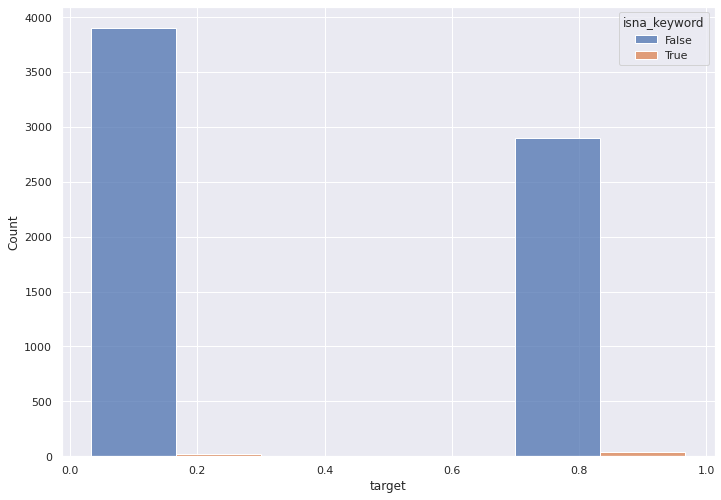

In [ ]:
%matplotlib inline

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data=df_train, x="target", hue="isna_keyword", multiple="dodge", shrink=.8, bins=3)
plt.show()

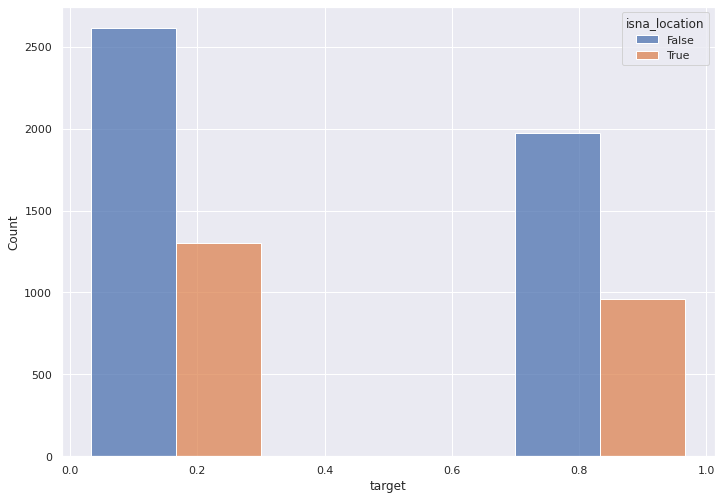

In [ ]:
%matplotlib inline

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data=df_train, x="target", hue="isna_location", multiple="dodge", shrink=.8, bins=3)
plt.show()

1. of **NaN** has influence to target base on histplots

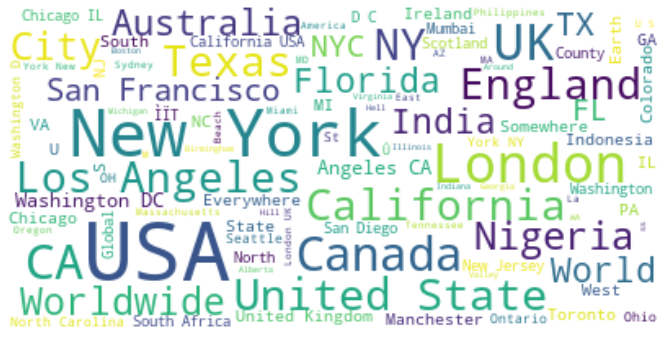

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline

text = " ".join(map(str, data[~data['location'].isna()]['location'].values))

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
data[~data['location'].isna()]['location'].value_counts()[:5]

USA              104
New York          71
United States     50
London            45
Canada            29
Name: location, dtype: int64

In [ ]:
len(data['location'].unique())

3342

Many different unique word means that OHE will have very big size, i will delete `location` column

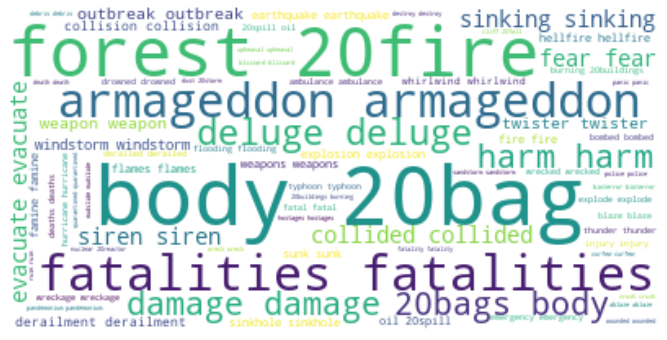

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline

text = " ".join(map(str, data[~data['keyword'].isna()]['keyword'].values))

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The `keyword` column will be convert to sentiment score by NLTK librarys, VADER pre-trained model

In [ ]:
data['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [ ]:
df_train['avail_tg'] = df_train['text'].str.contains(r'http[s]?://t.co/\w*\s?', regex=True)

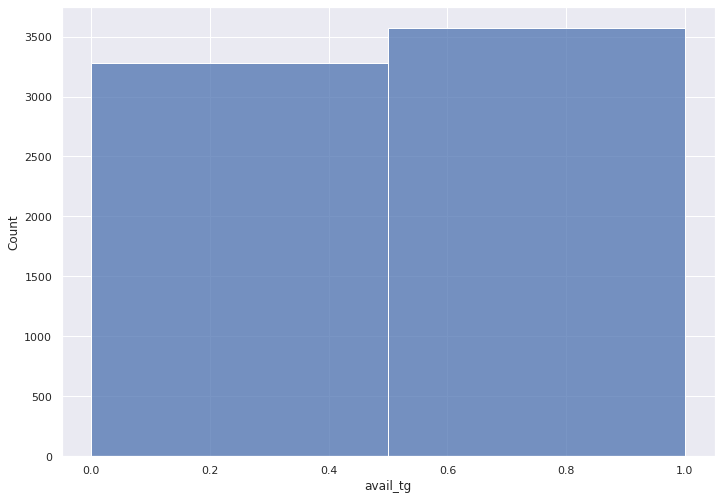

In [ ]:
sns.histplot(df_train['avail_tg'], bins=2)
plt.show()

0. Dublicates +
1. length of tweet +
2. Style of text +

The text have duplicates and the target of someone one row can be 0 or 1 at the same time. It is mistake in the data and count of duplicate rows is low, then i will delete those rows

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("cffl/bert-base-styleclassification-subjective-neutral")

model = AutoModelForSequenceClassification.from_pretrained("cffl/bert-base-styleclassification-subjective-neutral")

In [ ]:
from transformers import pipeline

classify = pipeline(
    task="text-classification",
    model=model,
    tokenizer = tokenizer,
    return_all_scores=True,
)

In [ ]:
distrib_target_zero = df_train[df_train['target'] == 0]['text'].apply(classify)

In [ ]:
distrib_sub_target_zero = [distrib_target_zero.values[i][0]['score'] for i in range(len(distrib_target_zero))]
distrib_neut_target_zero = [distrib_target_zero.values[i][1]['score'] for i in range(len(distrib_target_zero))]

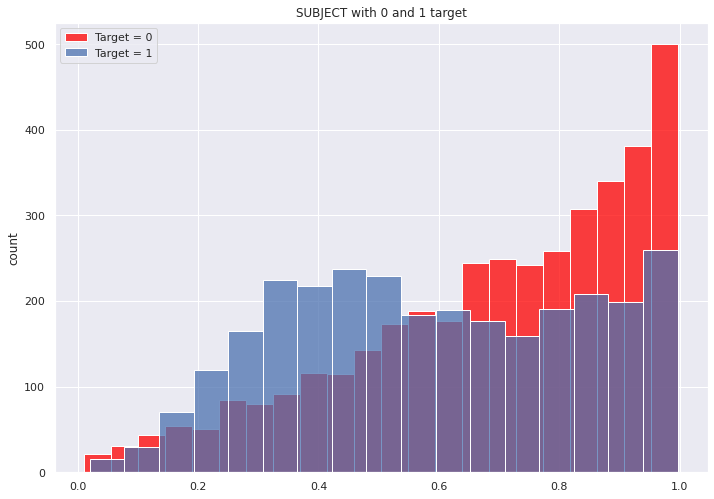

In [ ]:
ax = sns.histplot(distrib_sub_target_zero, color='red', label="Target = 0").set_title("SUBJECT with 0 and 1 target")
ax = sns.histplot(distrib_sub_target_one, label="Target = 1")
ax.set(xlabel='', ylabel='count')
ax.legend()
plt.show()

Based graphics the style of text influence on disaster

In [2]:
class list_lemmatization():
    
    def __init__(self):
        self.morph = pymorphy2.MorphAnalyzer()

    def lematize_text(self, text: str) -> str: 
        """
        Return lematizing text
        """
        return self.morph.parse(text)[0].normal_form    
        
    def lematize_corpus(self, texts: List[str]) -> List[str]: 
        """
        Return lematizing the list of strings
        """
        return [self.lematize_text(text) for text in texts]

In [3]:
import string

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder

class data_preproccesing():

    def __init__(self, data: pd.DataFrame, obj_lemmatization: list_lemmatization, classify, train=True):
        """
        data -> pd.DataFrame: The input data whose we want to change
        obj_lemmatization -> list_lemmatization: the object for lemmatization list
        classify : The style classification model
        tran -> bool: True for preproccesing train dataset, False for preproccesing test dataset
        """
        self.data = data
        self.obj_lemmatization = obj_lemmatization
        self.classify = classify
        self.train = train
    
    def get_feature_columns(self):
        self.data['len_text'] = self.data['text'].apply(len)
        self.data['count_dogs'] = self.data['text'].str.count('@')
        self.data['count_hashtag'] = self.data['text'].str.count('#')
        self.data['count_links'] = self.data['text'].str.count(r'http(s)?://')
        self.data['isna_keyword'] = self.data['keyword'].isna()
        self.data['isna_location'] = self.data['location'].isna()
        # add new column -> existing link
        self.data['avail_tg'] = self.data['text'].str.contains(r'http[s]?://t.co/\w*\s?', regex=True)
        return self.data
    
    def create_sentiment_score(self):
        """
        calculate sentiment score
        """
        def sentiment_scores(sentence):

            # Create a SentimentIntensityAnalyzer object.
            sid_obj = SentimentIntensityAnalyzer()

            # polarity_scores method of SentimentIntensityAnalyzer
            # object gives a sentiment dictionary.
            # which contains pos, neg, neu, and compound scores.
            sentiment_dict = sid_obj.polarity_scores(sentence)

            return sentiment_dict['compound']
        
        self.data['keyword'] = self.data['keyword'].fillna('')
        self.data['sentiment_score'] = self.data['keyword'].apply(sentiment_scores)
        return self.data
    
    
    def get_style(self):
        distrib = self.data['text'].apply(self.classify)
        
        if train:
            distrib_sub = [distrib.values[i][0]['score'] for i in range(len(distrib))]
        else:
            distrib_sub = [distrib.values[i][0][0]['score'] for i in range(len(distrib))]
        
        self.data['style_sub_score'] = distrib_sub
        
        return self.data
    
    def drop_duplicates(self):
        df_dublicates = self.data.groupby(['text']).nunique().sort_values(by='id', ascending=False).reset_index()
        smaller = df_dublicates[df_dublicates['target'] != 1]['text']
        larger = self.data['text']
        larger_rev = pd.Series(larger.index, larger.values)
        # indexes of duplicates of mistake target
        res = larger_rev[smaller].values
        self.data = self.data.drop(res)
        self.data = self.data.drop_duplicates(subset=['text'])
        return self.data
    
    def lemmatization_text(self):
        lem = self.obj_lemmatization
        self.data['text'] = lem.lematize_corpus(self.data['text'].values)
        return self.data
    
    def regex_preproc(self):
        # replace %20 to space
        self.data['keyword'] = self.data['keyword'].str.replace(r'%20', ' ')
        # delete links
        self.data['text'] = self.data['text'].str.replace(r'http[s]?://t.co/\w*\s?', '')
        # delete '\n'
        self.data['text'] = self.data['text'].str.replace('\n', '', regex=True)
        # delete not utf-8 symbols
        self.data['text'] = self.data['text'].apply(lambda x: ''.join(["" if ord(i) < 32 or ord(i) > 126 else i for i in x]))
        # delete all stop words
        translator = str.maketrans('', '', string.punctuation)
        self.data['text'] = self.data['text'].str.translate(translator)
        
        return self.data
    
    def delete_columns(self):
        self.data = self.data.drop(columns=['keyword', 'location'])
        return self.data
    
    def get_features(self):
        if self.train:
            self.data = self.get_feature_columns()
            self.data = self.create_sentiment_score()
            self.data = self.get_style()
            self.data = self.drop_duplicates()
            self.data = self.lemmatization_text()
            self.data = self.regex_preproc()
            self.data = self.delete_columns()
        else:
            self.data = self.get_feature_columns()
            self.data = self.create_sentiment_score()
            #self.data = self.get_style()
            self.data = self.lemmatization_text()
            self.data = self.regex_preproc()
            self.data = self.delete_columns()
        return self.data
    
    def t_get_features(self):
        if self.train:
            self.data = self.delete_columns()
        else:
            self.data = self.delete_columns()
        return self.data

In [4]:
tokenizer = AutoTokenizer.from_pretrained("cffl/bert-base-styleclassification-subjective-neutral")

model = AutoModelForSequenceClassification.from_pretrained("cffl/bert-base-styleclassification-subjective-neutral")

classify = pipeline(
    task="text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
)

In [ ]:
obj_lemmatization = list_lemmatization()

prep_train = data_preproccesing(df_train, obj_lemmatization, classify, train=True)
prep_test = data_preproccesing(df_test, obj_lemmatization, classify, train=False)

df_train = prep_train.get_features()
df_test = prep_test.get_features()

df_train.to_csv('df_train.csv', index=False)
df_test.to_csv('df_test.csv', index=False)

# Create Model

In [5]:
df_train = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv')

In [6]:
df_train.head()

,id,text,target,len_text,count_dogs,count_hashtag,count_links,isna_keyword,isna_location,avail_tg,sentiment_score,style_sub_score
0,6568,mcfadden reportedly to test hamstring thursday...,0,87,1,0,1,False,False,True,-0.4215,0.175402
1,4107,w nema warns nigerians to prepare for drought,1,77,0,0,1,False,False,True,0.0000,0.530845
2,4448,when i was cooking earlier i got electrocuted ...,0,85,0,0,0,False,True,False,0.0000,0.923776
3,5330,im on fire,0,36,0,0,1,False,False,True,-0.3400,0.611064
4,7552,more than 40 families affected by the fatal ou...,1,136,0,0,1,False,False,True,0.0000,0.390426


In [7]:
all_df_train = pd.concat([df_train, df_test])

In [8]:
class TextDataset(Dataset):
    def __init__(self, 
                 text: np.array, 
                 targets: np.array, 
                 tokenizer: transformers.models.bert.tokenization_bert.BertTokenizer, 
                 max_len: int):
        """
        text -> np.array: tweets in data
        targets -> np.array: targets of disaster
        tokenizer -> BertTokenizer: Tokenize text to tokens
        max_len -> int: size of encoding tweet
        """
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
        tweet = str(self.text[idx])
        target = self.targets[idx]
        
        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens = True, # add [CLS] and [PAD]
            max_length = self.max_len,
            return_token_type_ids = False,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }    

def createTextDataLoader(df: pd.DataFrame, tokenizer, max_len: int, batch_size: int):
    ds = TextDataset(
    text=df['text'].to_numpy(),
    targets=df['target'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size
    )



class TransformFeatureDataset(Dataset):
    def __init__(self,
                features: np.array,
                targets: np.array):
    
        self.features = torch.from_numpy(features.astype(np.float32))
        self.targets =  torch.from_numpy(targets.astype(np.float32))
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]
       
def createFeatureDataLoader(df: pd.DataFrame, batch_size: int):
    ds = TransformFeatureDataset(
    features=df.drop(columns=['text', 'id', 'target']).to_numpy(),
    targets=df['target'].to_numpy(),
    )

    return DataLoader(
        ds,
        batch_size=batch_size
    )

In [9]:
PRE_TRAINED_MODEL_NAME = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [12]:
RANDOM_SEED = 42
MAX_LEN = 128

os.environ["TOKENIZERS_PARALLELISM"] = "True"

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
BATCH_SIZE = 12

train_data_text_loader = createTextDataLoader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_text_loader = createTextDataLoader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

train_data_feature_loader = createFeatureDataLoader(df_train, BATCH_SIZE)
test_data_feature_loader = createFeatureDataLoader(df_test, BATCH_SIZE)

train_all_data_text_loader = createTextDataLoader(all_df_train, tokenizer, MAX_LEN, BATCH_SIZE)
train_all_data_feature_loader = createFeatureDataLoader(all_df_train, BATCH_SIZE)

In [14]:
class DisasterClassifier(nn.Module):
    
    def __init__(self, len_features):
        super(DisasterClassifier, self).__init__()
        self.len_features = len_features
        
        self.robert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        
        self.dropout_pooler_features = nn.Dropout(p=0.1)
        self.dropout_linear = nn.Dropout(p=0.4)
        
        self.norm_linear = nn.BatchNorm1d(128)
        
        self.linear_pooler = nn.Linear(self.robert.config.hidden_size+self.len_features, 128)
        self.linear_out = nn.Linear(128, 2)
        
        self.relu = nn.ReLU()
    
    def forward(self, input_ids, attention_mask, features):
        output = self.robert(input_ids=input_ids, 
                             attention_mask=attention_mask)
        
        # dropout
        output_pooler = self.dropout_pooler_features(output['pooler_output'])
        output_features = self.dropout_pooler_features(features)
            
        output =  torch.cat((output_pooler, output_features), 1)
        
        output = self.linear_pooler(output)
        output = self.norm_linear(output)
        output = self.relu(output)
        
        output = self.linear_out(output)
        output = self.dropout_linear(output)
                
        return output

In [15]:
model = DisasterClassifier(9)
model = model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = EPOCHS*len(train_data_feature_loader)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [17]:
def get_f1_score(output: torch.tensor, targets: torch.tensor):
    _, y_preds = torch.max(torch.round(torch.sigmoid(output)), 1)
    return f1_score(targets.cpu().detach().numpy(), y_preds.cpu().detach().numpy())

In [18]:
def train_epoch(model, 
         data_text_loader,
         data_feature_loader,
         loss_fn,
         optimizer,
         scheduler,
         device):
    
    losses = []
    f1_scores = []
    model = model.train()
    
    for data_text, data_features in zip(data_text_loader, data_feature_loader):
        input_ids = data_text['input_ids'].to(device)
        attention_mask = data_text['attention_mask'].to(device)
        features = data_features[0].to(device)
        targets = data_features[1].type(torch.LongTensor).to(device)
        
        output = model.forward(input_ids, attention_mask, features)
        f1_scores.append(get_f1_score(output, targets))
        
        loss = loss_fn(output, targets)
        
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return np.mean(f1_scores), np.mean(losses)

In [19]:
def eval_model(model, 
         data_text_loader,
         data_feature_loader,
         loss_fn,
         device):
    
    losses = []
    f1_scores = []
    
    model = model.eval()
    
    with torch.no_grad():
        for data_text, data_features in zip(data_text_loader, data_feature_loader):

            input_ids = data_text['input_ids'].to(device)
            attention_mask = data_text['attention_mask'].to(device)
            features = data_features[0].to(device)
            targets = data_features[1].type(torch.LongTensor).to(device)

            output = model.forward(input_ids, attention_mask, features)
            f1_scores.append(get_f1_score(output, targets))
            loss = loss_fn(output, targets)

            losses.append(loss.item())

    return np.mean(f1_scores), np.mean(losses)

In [20]:
history = defaultdict(list)
best_f1_score = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_f1_score, train_loss = train_epoch(
        model,
        train_all_data_text_loader,
        train_all_data_feature_loader,
        loss_fn, 
        optimizer, 
        scheduler,
        device
    )

    print(f'Train loss {train_loss} f1_score {train_f1_score}')

    val_f1_score, val_loss = eval_model(
        model,
        train_data_text_loader,
        train_data_feature_loader,
        loss_fn, 
        device
    )

    print(f'Val   loss {val_loss} f1_score {val_f1_score}')
    print()

    history['train_f1_score'].append(train_f1_score)
    history['train_loss'].append(train_loss)
    history['val_f1_score'].append(val_f1_score)
    history['val_loss'].append(val_loss)
    
    #torch.save(model.state_dict(), '/content/drive/MyDrive/data/best_model_state.bin')
    best_f1_score = val_f1_score

Epoch 1/10
----------
Train loss 0.6783968125478909 f1_score 0.06484113153442228
Val   loss 0.6530466492603769 f1_score 0.14803477556585903

Epoch 2/10
----------
Train loss 0.669979848134251 f1_score 0.15688387757077854
Val   loss 0.6496171878243848 f1_score 0.24279322414313534

Epoch 3/10
----------
Train loss 0.669833528586089 f1_score 0.20723868782974209
Val   loss 0.6479343752877962 f1_score 0.16000462927638773

Epoch 4/10
----------
Train loss 0.5777731609230224 f1_score 0.4345804621363727
Val   loss 0.4822728621440925 f1_score 0.634210471380046

Epoch 5/10
----------
Train loss 0.5131140029468475 f1_score 0.5385603037360225
Val   loss 0.42180406361765377 f1_score 0.7833807506623964

Epoch 6/10
----------
Train loss 0.49495139701393087 f1_score 0.5647885572006978
Val   loss 0.39434401704193645 f1_score 0.8142315072497531

Epoch 7/10
----------
Train loss 0.47816888548838443 f1_score 0.5550914474237159
Val   loss 0.34434311915698523 f1_score 0.8251815168519412

Epoch 8/10
--------

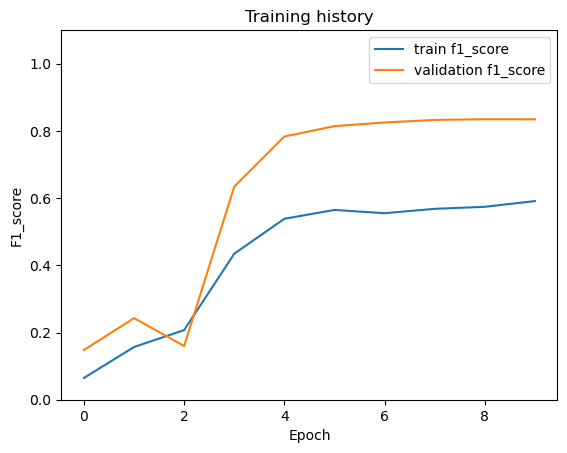

In [21]:
plt.plot(history['train_f1_score'], label='train f1_score')
plt.plot(history['val_f1_score'], label='validation f1_score')

plt.title('Training history')
plt.ylabel('F1_score')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1.1]);

In [ ]:
model = torch.load('/kaggle/working/best_model_state.bin', map_location='cpu')

# Eval

In [ ]:
PATH_MODEL = '/content/drive/MyDrive/data/best_model_state.bin'
model = DisasterClassifier(9)
model.load_state_dict(torch.load(PATH_MODEL, map_location=torch.device('cpu')))
model.to(device)
model.eval()
pass

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
df_valid = pd.read_csv("/content/drive/MyDrive/data/test.csv")

In [ ]:
df_valid.head()

,id,keyword,location,text,style_sub_score
0,0,NaN,NaN,Just happened a terrible car crash,0.943307
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0.574726
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0.799841
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0.797793
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,0.578825


In [ ]:
obj_lemmatization = list_lemmatization()
prep_valid = data_preproccesing(df_valid, obj_lemmatization, classify, train=False)
df_valid = prep_valid.get_features()
df_valid.to_csv('/content/drive/MyDrive/data/df_valid.csv', index=False)

In [ ]:
df_valid = pd.read_csv("/content/drive/MyDrive/data/df_valid.csv")

In [ ]:
class ValidTextDataset(Dataset):
    def __init__(self, 
                 text: np.array, 
                 tokenizer: transformers.models.bert.tokenization_bert.BertTokenizer, 
                 max_len: int):
        """
        text -> np.array: tweets in data
        targets -> np.array: targets of disaster
        tokenizer -> BertTokenizer: Tokenize text to tokens
        max_len -> int: size of encoding tweet
        """
        self.text = text
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
        tweet = str(self.text[idx])
        
        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens = True, # add [CLS] and [PAD]
            max_length = self.max_len,
            return_token_type_ids = False,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }    

def createValidTextDataLoader(df: pd.DataFrame, tokenizer, max_len: int, batch_size: int):
    ds = ValidTextDataset(
    text=df['text'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers = 4
    )

class ValidTransformFeatureDataset(Dataset):
    def __init__(self,
                features: np.array):
    
        self.features = torch.from_numpy(features.astype(np.float32))
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx]
       
def createValidFeatureDataLoader(df: pd.DataFrame, batch_size: int):
    ds = ValidTransformFeatureDataset(
    features=df.drop(columns=['text', 'id']).to_numpy())

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers = 4
    )

In [ ]:
valid_data_text_loader = createValidTextDataLoader(df_valid, tokenizer, MAX_LEN, BATCH_SIZE)
valid_data_feature_loader = createValidFeatureDataLoader(df_valid, BATCH_SIZE)

In [ ]:
predicts = np.array([])
with torch.no_grad():
    for data_text, data_features in zip(valid_data_text_loader, valid_data_feature_loader):

        input_ids = data_text['input_ids'].to(device)
        attention_mask = data_text['attention_mask'].to(device)
        features = data_features.to(device)
        targets = data_features[1].type(torch.LongTensor).to(device)

        output = model.forward(input_ids, attention_mask, features)
        _, y_preds = torch.max(torch.round(torch.sigmoid(output)), 1)
        predicts = np.append(predicts, y_preds.cpu().detach().numpy())        

In [ ]:
d = {'target': map(int, predicts)}
sub = pd.DataFrame(data=d)
sub['id'] = df_valid['id'].values
sub.to_csv('/content/drive/MyDrive/data/subs.csv', index=False)

In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/data/subs.csv')
sub

,target,id
0,1,0
1,1,2
2,1,3
3,1,9
4,1,11
...,...,...
3258,0,10861
3259,1,10865
3260,1,10868
3261,1,10874
